# Using CellTypist for cell type classification
This notebook showcases the cell type classification for scRNA-seq query data by retrieving the most likely cell type labels from either the built-in CellTypist models or the user-trained custom models.

Only the main steps and key parameters are introduced in this notebook. Refer to detailed [Usage](https://github.com/Teichlab/celltypist#usage) if you want to learn more.

## Install CellTypist

In [2]:
import scanpy as sc

In [3]:
import celltypist
from celltypist import models
import json

## Download a scRNA-seq dataset of 2,000 immune cells

In [4]:
config_json = r"C:\Users\rafaelo\OneDrive - NTNU\Documents\Projects\STNav\configs\analysis.json"
# Open config json with json.load
config_total = json.load(open(config_json, 'r'))
config = config_total["ST"]


In [5]:
adata_2000 = sc.read_visium(
	path=config["path"],
	count_file=config["count_file"],
	load_images=config["load_images"],
	source_image_path=config["source_image_path"],
)

adata_2000.var_names_make_unique()


This dataset includes 2,000 cells and 18,950 genes collected from different studies, thereby showing the practical applicability of CellTypist.

In [6]:
adata_2000.shape

(152048, 18085)

In [7]:
adata_2000.X.expm1().sum(axis = 1)

matrix([[1.4815249e+07],
        [2.2759511e+02],
        [9.1438325e+05],
        ...,
        [1.9731723e+11],
        [          inf],
        [1.1720600e+16]], dtype=float32)

In [8]:
sc.pp.normalize_total(adata_2000)
adata_2000.X.expm1().sum(axis = 1)

matrix([[8.9112694e+05],
        [4.8119262e+28],
        [2.7309672e+06],
        ...,
        [6.6003215e+09],
        [5.0186500e+26],
        [5.7505376e+12]], dtype=float32)

In [9]:
sc.pp.log1p(adata_2000)

The expression matrix (`adata_2000.X`) is pre-processed (and required) as log1p normalised expression to 10,000 counts per cell (this matrix can be alternatively stashed in `.raw.X`).

In [10]:
adata_2000.X.expm1().sum(axis = 1)

matrix([[1518.9998],
        [1518.9999],
        [1519.    ],
        ...,
        [1519.    ],
        [1518.9998],
        [1519.    ]], dtype=float32)

Some pre-assigned cell type labels are also in the data, which will be compared to the predicted labels from CellTypist later.

In [11]:
adata_2000.obs

,in_tissue,array_row,array_col
s_016um_00052_00082-1,1,52,82
s_016um_00010_00367-1,1,10,367
s_016um_00163_00399-1,1,163,399
s_016um_00238_00388-1,1,238,388
s_016um_00144_00175-1,1,144,175
...,...,...,...
s_016um_00375_00231-1,1,375,231
s_016um_00109_00223-1,1,109,223
s_016um_00039_00175-1,1,39,175
s_016um_00037_00193-1,1,37,193


## Assign cell type labels using a CellTypist built-in model
In this section, we show the procedure of transferring cell type labels from built-in models to the query dataset.

Download the latest CellTypist models.

In [12]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 44
📂 Storing models in C:\Users\rafaelo\.celltypist\data\models
💾 Downloading model [1/44]: Immune_All_Low.pkl
💾 Downloading model [2/44]: Immune_All_High.pkl
💾 Downloading model [3/44]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [4/44]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [5/44]: Adult_Human_Skin.pkl
💾 Downloading model [6/44]: Adult_Mouse_Gut.pkl
💾 Downloading model [7/44]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [8/44]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [9/44]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [10/44]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [11/44]: COVID19_HumanChallenge_Blood.pkl
💾 Downloading model [12/44]: COVID19_Immune_Landscape.pkl
💾 Downloading model [13/44]: Cells_Fetal_Lung.pkl
💾 Downloading model [14/44]: Cells_Intestinal_Tract.pkl
💾 Downloading model [15/44]: Cells_Lung_Airwa

All models are stored in `models.models_path`.

In [13]:
models.models_path

'C:\\Users\\rafaelo\\.celltypist\\data\\models'

Get an overview of the models and what they represent.

In [14]:
models.models_description()

👉 Detailed model information can be found at `https://www.celltypist.org/models`


,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_CynomolgusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult cynom...
3,Adult_Human_PancreaticIslet.pkl,cell types from pancreatic islets of healthy a...
4,Adult_Human_Skin.pkl,cell types from human healthy adult skin
5,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...
6,Adult_Mouse_OlfactoryBulb.pkl,cell types from the olfactory bulb of adult mice
7,Adult_Pig_Hippocampus.pkl,cell types from the adult pig hippocampus
8,Adult_RhesusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult rhesu...
9,Autopsy_COVID19_Lung.pkl,cell types from the lungs of 16 SARS-CoV-2 inf...


Choose the model you want to employ, for example, the model with all tissues combined containing low-hierarchy (high-resolution) immune cell types/subtypes.

In [15]:
# Indeed, the `model` argument defaults to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Human_Lung_Atlas.pkl')

Show the model meta information.

In [16]:
model

CellTypist model with 61 cell types and 5017 features
    date: 2023-05-17 19:51:55.661237
    details: integrated Human Lung Cell Atlas (HLCA) combining multiple datasets of the healthy respiratory system
    source: https://doi.org/10.1101/2022.03.10.483747
    version: v2
    cell types: AT0, AT1, ..., pre-TB secretory
    features: TSPAN6, FGR, ..., RP1-34B20.21

This model contains 98 cell states.

In [17]:
model.cell_types

array(['AT0', 'AT1', 'AT2', 'AT2 proliferating',
       'Adventitial fibroblasts', 'Alveolar Mph CCL3+',
       'Alveolar Mph MT-positive', 'Alveolar Mph proliferating',
       'Alveolar fibroblasts', 'Alveolar macrophages', 'B cells',
       'Basal resting', 'CD4 T cells', 'CD8 T cells',
       'Classical monocytes', 'Club (nasal)', 'Club (non-nasal)', 'DC1',
       'DC2', 'Deuterosomal', 'EC aerocyte capillary', 'EC arterial',
       'EC general capillary', 'EC venous pulmonary',
       'EC venous systemic', 'Goblet (bronchial)', 'Goblet (nasal)',
       'Goblet (subsegmental)', 'Hematopoietic stem cells',
       'Hillock-like', 'Interstitial Mph perivascular', 'Ionocyte',
       'Lymphatic EC differentiating', 'Lymphatic EC mature',
       'Lymphatic EC proliferating', 'Mast cells', 'Mesothelium',
       'Migratory DCs', 'Monocyte-derived Mph', 'Multiciliated (nasal)',
       'Multiciliated (non-nasal)', 'Myofibroblasts', 'NK cells',
       'Neuroendocrine', 'Non-classical monocytes

Transfer cell type labels from this model to the query dataset using [celltypist.annotate](https://celltypist.readthedocs.io/en/latest/celltypist.annotate.html).

In [18]:
# Not run; predict cell identities using this loaded model.
#predictions = celltypist.annotate(adata_2000, model = model, majority_voting = True)
# Alternatively, just specify the model name (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata_2000, model = 'Human_Lung_Atlas.pkl', majority_voting = True,mode = 'prob match', p_thres = 0.1)

⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 152048 cells and 18085 genes
🔗 Matching reference genes in the model


🧬 4503 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


By default (`majority_voting = False`), CellTypist will infer the identity of each query cell independently. This leads to raw predicted cell type labels, and usually finishes within seconds or minutes depending on the size of the query data. You can also turn on the majority-voting classifier (`majority_voting = True`), which refines cell identities within local subclusters after an over-clustering approach at the cost of increased runtime.

The results include both predicted cell type labels (`predicted_labels`), over-clustering result (`over_clustering`), and predicted labels after majority voting in local subclusters (`majority_voting`). Note in the `predicted_labels`, each query cell gets its inferred label by choosing the most probable cell type among all possible cell types in the given model.

In [19]:
predictions.predicted_labels["predicted_labels"].value_counts()

Unassigned                                                                                                                                                                     41725
Neuroendocrine                                                                                                                                                                 26645
Basal resting                                                                                                                                                                  15102
Basal resting|Neuroendocrine                                                                                                                                                   11063
NK cells|Neuroendocrine                                                                                                                                                         5462
                                                                                               

Transform the prediction result into an `AnnData`.

In [20]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata(insert_prob = True)

Compared to `adata_2000`, the new `adata` has additional prediction information in `adata.obs` (`predicted_labels`, `over_clustering`, `majority_voting` and `conf_score`). Of note, all these columns can be prefixed with a specific string by setting `prefix` in [to_adata](https://celltypist.readthedocs.io/en/latest/celltypist.classifier.AnnotationResult.html#celltypist.classifier.AnnotationResult.to_adata).

In [21]:
adata.obs

,in_tissue,array_row,array_col,predicted_labels,over_clustering,majority_voting,conf_score,AT0,AT1,AT2,...,SMG mucous,SMG serous (bronchial),SMG serous (nasal),Smooth muscle,Smooth muscle FAM83D+,Subpleural fibroblasts,Suprabasal,T cells proliferating,Tuft,pre-TB secretory
s_016um_00052_00082-1,1,52,82,CD4 T cells|Club (non-nasal)|Neuroendocrine,33,Unassigned,0.637232,0.099783,0.039584,0.006858,...,0.017031,0.001707,1.832217e-04,0.027520,0.010882,0.000126,0.010273,0.002017,4.182371e-04,0.001827
s_016um_00010_00367-1,1,10,367,Smooth muscle,106,Unassigned,0.153186,0.001428,0.005547,0.002572,...,0.000317,0.000166,1.043171e-03,0.153186,0.000083,0.000025,0.002584,0.000124,3.186022e-04,0.000197
s_016um_00163_00399-1,1,163,399,Unassigned,52,Unassigned,0.057359,0.000039,0.000161,0.000915,...,0.000026,0.000063,8.960966e-07,0.001731,0.000008,0.000003,0.000874,0.000006,1.286108e-06,0.000673
s_016um_00238_00388-1,1,238,388,Basal resting,515,Unassigned,0.407854,0.000038,0.001625,0.000016,...,0.000472,0.001298,1.380388e-05,0.002102,0.000024,0.000024,0.001340,0.000924,7.247142e-06,0.002976
s_016um_00144_00175-1,1,144,175,Neuroendocrine,846,Unassigned,0.134728,0.000048,0.000118,0.000483,...,0.000029,0.000390,5.137045e-06,0.000673,0.000113,0.000005,0.003761,0.000028,1.402936e-06,0.000129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_016um_00375_00231-1,1,375,231,Unassigned,30,Unassigned,0.088563,0.000132,0.000445,0.000252,...,0.000023,0.000044,9.583161e-07,0.007620,0.000002,0.000003,0.000101,0.000007,1.321957e-07,0.000009
s_016um_00109_00223-1,1,109,223,NK cells|Neuroendocrine,659,Neuroendocrine,0.952083,0.001286,0.021967,0.000151,...,0.007495,0.000817,1.347567e-06,0.000409,0.000167,0.000009,0.009401,0.000407,7.131820e-06,0.003284
s_016um_00039_00175-1,1,39,175,Neuroendocrine,1095,Unassigned,0.990639,0.002113,0.000627,0.000658,...,0.000343,0.001353,2.570592e-06,0.001403,0.000976,0.000002,0.000799,0.000077,1.285691e-07,0.000554
s_016um_00037_00193-1,1,37,193,Unassigned,33,Unassigned,0.018166,0.000018,0.000451,0.000781,...,0.000132,0.000022,4.145345e-06,0.000158,0.000036,0.000004,0.000058,0.000109,3.600134e-06,0.000262


In addition to this meta information added, the neighborhood graph constructed during over-clustering is also stored in the `adata`
(If a pre-calculated neighborhood graph is already present in the `AnnData`, this graph construction step will be skipped).  
This graph can be used to derive the cell embeddings, such as the UMAP coordinates.

In [22]:
import matplotlib.pyplot as plt


In [23]:
list(adata.obs.predicted_labels)

['CD4 T cells|Club (non-nasal)|Neuroendocrine',
 'Smooth muscle',
 'Unassigned',
 'Basal resting',
 'Neuroendocrine',
 'NK cells|Neuroendocrine',
 'EC general capillary|NK cells|Neuroendocrine',
 'Basal resting',
 'Unassigned',
 'Unassigned',
 'AT2 proliferating|Adventitial fibroblasts|Basal resting|EC general capillary|EC venous systemic|NK cells|Neuroendocrine',
 'Basal resting',
 'Basal resting|Neuroendocrine',
 'Basal resting|EC venous systemic|Interstitial Mph perivascular|NK cells|Neuroendocrine|SMG mucous',
 'Basal resting|Neuroendocrine',
 'Basal resting',
 'Basal resting|CD4 T cells|EC general capillary|NK cells|Neuroendocrine',
 'Unassigned',
 'Unassigned',
 'Neuroendocrine',
 'Neuroendocrine',
 'Neuroendocrine',
 'Unassigned',
 'Basal resting|Neuroendocrine',
 'Unassigned',
 'Basal resting|NK cells|Neuroendocrine',
 'Unassigned',
 'Basal resting',
 'Basal resting|CD8 T cells',
 'Unassigned',
 'Basal resting|CD4 T cells|Club (non-nasal)|Neuroendocrine',
 'Unassigned',
 'Basal

In [24]:
adata.obs.columns

Index(['in_tissue', 'array_row', 'array_col', 'predicted_labels',
       'over_clustering', 'majority_voting', 'conf_score', 'AT0', 'AT1', 'AT2',
       'AT2 proliferating', 'Adventitial fibroblasts', 'Alveolar Mph CCL3+',
       'Alveolar Mph MT-positive', 'Alveolar Mph proliferating',
       'Alveolar fibroblasts', 'Alveolar macrophages', 'B cells',
       'Basal resting', 'CD4 T cells', 'CD8 T cells', 'Classical monocytes',
       'Club (nasal)', 'Club (non-nasal)', 'DC1', 'DC2', 'Deuterosomal',
       'EC aerocyte capillary', 'EC arterial', 'EC general capillary',
       'EC venous pulmonary', 'EC venous systemic', 'Goblet (bronchial)',
       'Goblet (nasal)', 'Goblet (subsegmental)', 'Hematopoietic stem cells',
       'Hillock-like', 'Interstitial Mph perivascular', 'Ionocyte',
       'Lymphatic EC differentiating', 'Lymphatic EC mature',
       'Lymphatic EC proliferating', 'Mast cells', 'Mesothelium',
       'Migratory DCs', 'Monocyte-derived Mph', 'Multiciliated (nasal)',
    

Index(['AT0', 'AT1', 'AT2', 'AT2 proliferating', 'Adventitial fibroblasts',
       'Alveolar Mph CCL3+', 'Alveolar Mph MT-positive',
       'Alveolar Mph proliferating', 'Alveolar fibroblasts',
       'Alveolar macrophages', 'B cells', 'Basal resting', 'CD4 T cells',
       'CD8 T cells', 'Classical monocytes', 'Club (nasal)',
       'Club (non-nasal)', 'DC1', 'DC2', 'Deuterosomal',
       'EC aerocyte capillary', 'EC arterial', 'EC general capillary',
       'EC venous pulmonary', 'EC venous systemic', 'Goblet (bronchial)',
       'Goblet (nasal)', 'Goblet (subsegmental)', 'Hematopoietic stem cells',
       'Hillock-like', 'Interstitial Mph perivascular', 'Ionocyte',
       'Lymphatic EC differentiating', 'Lymphatic EC mature',
       'Lymphatic EC proliferating', 'Mast cells', 'Mesothelium',
       'Migratory DCs', 'Monocyte-derived Mph', 'Multiciliated (nasal)',
       'Multiciliated (non-nasal)', 'Myofibroblasts', 'NK cells',
       'Neuroendocrine', 'Non-classical monocytes',
    

MemoryError: Unable to allocate 363. MiB for an array with shape (6000, 5287, 3) and data type float32

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

MemoryError: Unable to allocate 484. MiB for an array with shape (6000, 5287, 4) and data type float32

<Figure size 640x480 with 2 Axes>

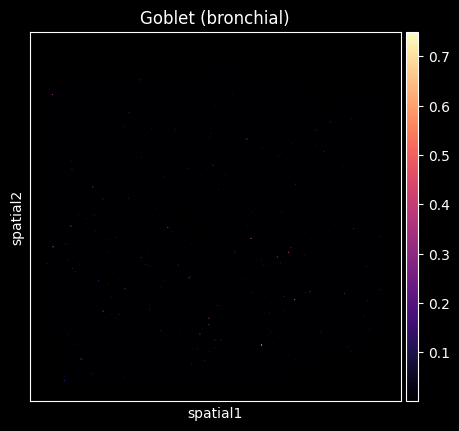

In [34]:
for cell_type in list(adata.obs.columns[7:]):
	if cell_type != "Unassigned":
		save_path =r"C:\Users\rafaelo\OneDrive - NTNU\Documents\Projects\STNav\notebooks\experimental\\" + cell_type + ".png"
		with plt.rc_context():  # Use this to set figure params like size and dpi
			plot_func = sc.pl.spatial(
				adata,
				cmap="magma",
				color=cell_type,
				img_key="hires",
				size=1.5,
				alpha_img=0.5,
				show=False,
			)
			plt.savefig(save_path, bbox_inches="tight")


In [48]:
# If the UMAP or any cell embeddings are already available in the `AnnData`, skip this command.
sc.tl.umap(adata)

Visualise the prediction results.

... storing 'feature_types' as categorical
... storing 'genome' as categorical


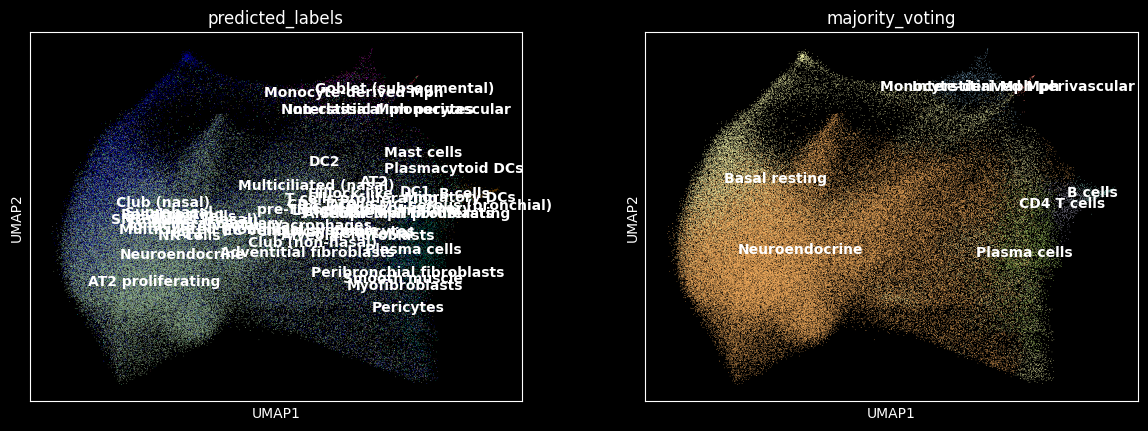

In [49]:
sc.pl.umap(adata, color = ['predicted_labels', 'majority_voting'], legend_loc = 'on data')

Actually, you may not need to explicitly convert `predictions` output by `celltypist.annotate` into an `AnnData` as above. A more useful way is to use the visualisation function [celltypist.dotplot](https://celltypist.readthedocs.io/en/latest/celltypist.dotplot.html), which quantitatively compares the CellTypist prediction result (e.g. `majority_voting` here) with the cell types pre-defined in the `AnnData` (here `cell_type`). You can also change the value of `use_as_prediction` to `predicted_labels` to compare the raw prediction result with the pre-defined cell types.

For each pre-defined cell type (each column from the dot plot), this plot shows how it can be 'decomposed' into different cell types predicted by CellTypist (rows).

## Assign cell type labels using a custom model
In this section, we show the procedure of generating a custom model and transferring labels from the model to the query data.

Use previously downloaded dataset of 2,000 immune cells as the training set.

In [1]:
adata_2000 = sc.read('celltypist_demo_folder/demo_2000_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_2000_cells.h5ad')

NameError: name 'sc' is not defined

Download another scRNA-seq dataset of 400 immune cells as a query.

In [ ]:
adata_400 = sc.read('celltypist_demo_folder/demo_400_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_400_cells.h5ad')

  0%|          | 0.00/7.62M [00:00<?, ?B/s]

Derive a custom model by training the data using the [celltypist.train](https://celltypist.readthedocs.io/en/latest/celltypist.train.html) function.

In [ ]:
# The `cell_type` in `adata_2000.obs` will be used as cell type labels for training.
new_model = celltypist.train(adata_2000, labels = 'cell_type', n_jobs = 10, feature_selection = True)

🍳 Preparing data before training
✂️ 2749 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 2607 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


Refer to the function [celltypist.train](https://celltypist.readthedocs.io/en/latest/celltypist.train.html) for what each parameter means, and to the [usage](https://github.com/Teichlab/celltypist#usage) for details of model training.

This custom model can be manipulated as with other CellTypist built-in models. First, save this model locally.

In [ ]:
# Save the model.
new_model.write('celltypist_demo_folder/model_from_immune2000.pkl')

You can load this model by `models.Model.load`.

In [ ]:
new_model = models.Model.load('celltypist_demo_folder/model_from_immune2000.pkl')

Next, we use this model to predict the query dataset of 400 immune cells.

In [ ]:
# Not run; predict the identity of each input cell with the new model.
#predictions = celltypist.annotate(adata_400, model = new_model, majority_voting = True)
# Alternatively, just specify the model path (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata_400, model = 'celltypist_demo_folder/model_from_immune2000.pkl', majority_voting = True)

🔬 Input data has 400 cells and 18950 genes
🔗 Matching reference genes in the model
🧬 2607 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [ ]:
adata = predictions.to_adata()

In [ ]:
sc.tl.umap(adata)

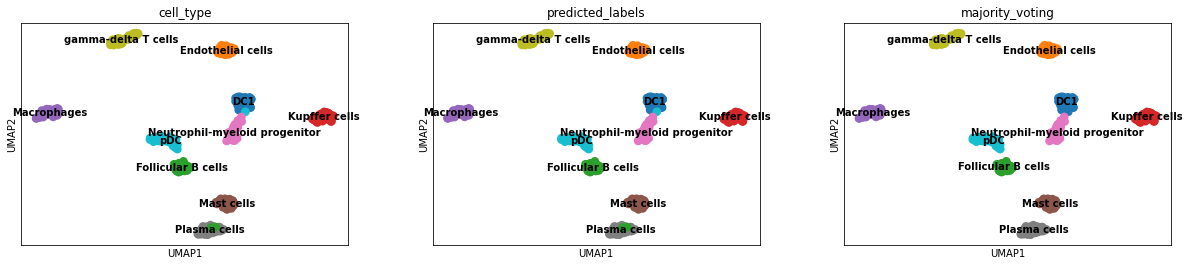

In [ ]:
sc.pl.umap(adata, color = ['cell_type', 'predicted_labels', 'majority_voting'], legend_loc = 'on data')

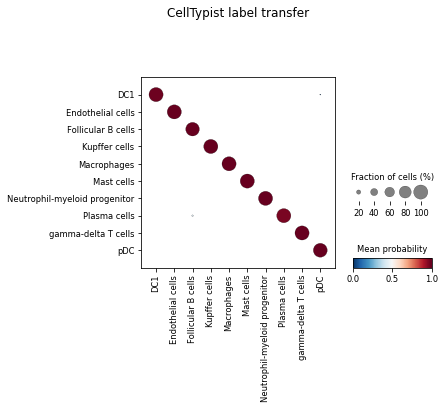

In [ ]:
celltypist.dotplot(predictions, use_as_reference = 'cell_type', use_as_prediction = 'majority_voting')

## Examine expression of cell type-driving genes

Each model can be examined in terms of the driving genes for each cell type. Note these genes are only dependent on the model, say, the training dataset.

In [ ]:
# Any model can be inspected.
# Here we load the previously saved model trained from 2,000 immune cells.
model = models.Model.load(model = 'celltypist_demo_folder/model_from_immune2000.pkl')

In [ ]:
model.cell_types

array(['DC1', 'Endothelial cells', 'Follicular B cells', 'Kupffer cells',
       'Macrophages', 'Mast cells', 'Neutrophil-myeloid progenitor',
       'Plasma cells', 'gamma-delta T cells', 'pDC'], dtype=object)

Extract the top three driving genes of `Mast cells` using the [extract_top_markers](https://celltypist.readthedocs.io/en/latest/celltypist.models.Model.html#celltypist.models.Model.extract_top_markers) method.

In [ ]:
top_3_genes = model.extract_top_markers("Mast cells", 3)
top_3_genes

array(['TPSB2', 'TPSAB1', 'CPA3'], dtype=object)

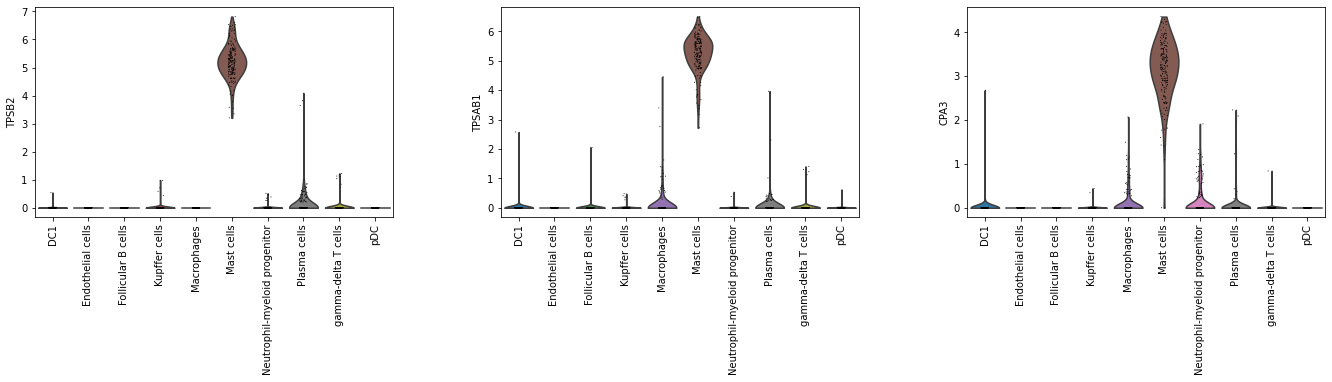

In [ ]:
# Check expression of the three genes in the training set.
sc.pl.violin(adata_2000, top_3_genes, groupby = 'cell_type', rotation = 90)

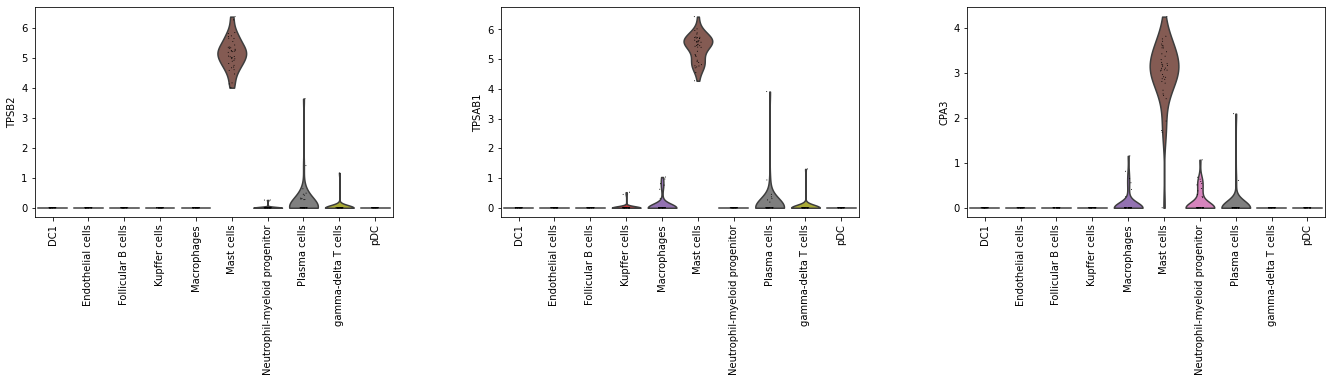

In [ ]:
# Check expression of the three genes in the query set.
# Here we use `majority_voting` from CellTypist as the cell type labels for this dataset.
sc.pl.violin(adata_400, top_3_genes, groupby = 'majority_voting', rotation = 90)